In [1]:
import os, re, pdb
import pandas as pd
import matplotlib.pyplot as plt
from natsort import natsorted 
import numpy as np

import time
import sys
sys.path.append('../')
sys.path.append('../cobs')

from model import Model
from occupancy_generator import OccupancyGenerator as OG

In [2]:
blind_object_list = ["WF-1", "WR-1", "WB-1", "WL-1"]
def setup(season, blinds, daylighting, ep_model, stpt, customize_occupancy):
    """
    param: blinds can be None, SouthOnly, All
    """
    if daylighting:
        dlight = 1
    else:
        dlight = 0

    if season == 'heating':
        heat = 1
        cool = 0
        reheat = 1
        blind_type = 'OnNightIfLowOutdoorTempAndOffDay'
#         stpt = 15
        run_period = (35, 1991, 1, 1)
    elif season == 'cooling':
        heat = 0
        cool = 1
        reheat = 0
        blind_type = 'OffNightAndOnDayIfCoolingAndHighSolarOnWindow'
#         stpt = 400
        run_period = (35, 1991, 7, 1)
    else:
        raise ValueError(f'Incorrect value for season: {season}')
        
    # turn off if blinds are not active
    if blinds is None:
        blind_type = 'AlwaysOff'
    elif blinds == 'SouthOnly':
        ep_model.set_blinds(
            blind_object_list[0],
            blind_material_name="White Painted Metal Blind",
            shading_control_type=blind_type,
            setpoint=stpt,
            agent_control=False
        )
    elif blinds == 'All':
        ep_model.set_blinds(
            blind_object_list,
            blind_material_name="White Painted Metal Blind",
            shading_control_type=blind_type,
            setpoint=stpt,
            agent_control=False
        )
    elif blinds == 'AllAlwaysOn':
        blind_type = 'AlwaysOn'
        ep_model.set_blinds(
            blind_object_list,
            blind_material_name="White Painted Metal Blind",
            shading_control_type=blind_type,
            setpoint=stpt,
            agent_control=False
        )
    else:
        raise ValueError(f"{blinds} is an invalid blind type.")
    
    # Set the run period for the defined season
    ep_model.set_runperiod(*run_period)

    # Set the coil availability based on the season
    ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'ReheatCoilAvailSched'}, {
        'Field 4': reheat
    })    
    ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'HeatingCoilAvailSched'}, {
        'Field 4': heat
    })
    ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'CoolingCoilAvailSched'}, {
        'Field 4': cool
    })

    # Setup Daylighting
    ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'DaylightingAvail'}, {
        'Field 4': dlight
    })
    
    if customize_occupancy:
        OG(ep_model, random_seed=42).generate_daily_schedule(add_to_model=True, 
                                             overwrite_dict={f"SPACE{i}-1": f"SPACE{i}-1 People 1"
                                                             for i in range(1, 6)})
        return f'SAT_SP_customOcc_{season}_blinds{blinds}_setpoint{stpt}_daylighting{daylighting}.csv', ep_model
    else:
        return f'SAT_SP_{season}_blinds{blinds}_setpoint{stpt}_daylighting{daylighting}.csv', ep_model

In [3]:
eplus_naming_dict = {
    ('Site Outdoor Air Drybulb Temperature', '*'): "Outdoor Temp.",
    ('Site Diffuse Solar Radiation Rate per Area', '*'): "Diff. Solar Rad.",
    ('Site Direct Solar Radiation Rate per Area', '*'): "Direct Solar Rad.",
    ('Facility Total HVAC Electric Demand Power', '*'): "HVAC Power",
    ('System Node Temperature', 'VAV SYS 1 OUTLET NODE'): "Sys Out Temp.",
    ('Heating Coil Electric Power', 'Main Heating Coil 1'): "Heat Coil Power",
    ('Cooling Coil Electric Power', 'Main Cooling Coil 1'): "Cool Coil Power",
    ('Occupancy Flag', '*'): "Occupancy Flag",
    ('System Node Temperature', 'Mixed Air Node 1'): "MA Temp.",
    ('Indoor Air Temperature Setpoint', '*'): "Indoor Temp. Setpoint",
    # node outputs
    ('System Node Temperature', 'SPACE1-1 IN NODE'): "In Node Temp Zone 1",
    ('System Node Temperature', 'SPACE2-1 IN NODE'): "In Node Temp Zone 2",
    ('System Node Temperature', 'SPACE3-1 IN NODE'): "In Node Temp Zone 3",
    ('System Node Temperature', 'SPACE4-1 IN NODE'): "In Node Temp Zone 4",
    ('System Node Temperature', 'SPACE5-1 IN NODE'): "In Node Temp Zone 5",
    
    ('System Node Mass Flow Rate', 'SPACE1-1 IN NODE'): "In Node Flow Zone 1",
    ('System Node Mass Flow Rate', 'SPACE2-1 IN NODE'): "In Node Flow Zone 2",
    ('System Node Mass Flow Rate', 'SPACE3-1 IN NODE'): "In Node Flow Zone 3",
    ('System Node Mass Flow Rate', 'SPACE4-1 IN NODE'): "In Node Flow Zone 4",
    ('System Node Mass Flow Rate', 'SPACE5-1 IN NODE'): "In Node Flow Zone 5",
    # Comfort
    ('Building Mean PPD', '*'): "PPD",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE1-1 People 1'): "PPD Zone 1",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE2-1 People 1'): "PPD Zone 2",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE3-1 People 1'): "PPD Zone 3",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE4-1 People 1'): "PPD Zone 4",
    ('Zone Thermal Comfort Fanger Model PPD', 'SPACE5-1 People 1'): "PPD Zone 5",
    
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE1-1 People 1'): "PMV Zone 1",
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE2-1 People 1'): "PMV Zone 2",
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE3-1 People 1'): "PMV Zone 3",
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE4-1 People 1'): "PMV Zone 4",
    ('Zone Thermal Comfort Fanger Model PMV', 'SPACE5-1 People 1'): "PMV Zone 5",
    # Zone Temps
    ('Building Mean Temperature', '*'): "Indoor Temp.",
    ('Zone Air Temperature', 'SPACE1-1'): "Temp Zone 1",
    ('Zone Air Temperature', 'SPACE2-1'): "Temp Zone 2",
    ('Zone Air Temperature', 'SPACE3-1'): "Temp Zone 3",
    ('Zone Air Temperature', 'SPACE4-1'): "Temp Zone 4",
    ('Zone Air Temperature', 'SPACE5-1'): "Temp Zone 5",
    # Lights
    ('Lights Electric Power', 'SPACE1-1 Lights 1'): 'Lights Zone 1',
    ('Lights Electric Power', 'SPACE2-1 Lights 1'): 'Lights Zone 2',
    ('Lights Electric Power', 'SPACE3-1 Lights 1'): 'Lights Zone 3',
    ('Lights Electric Power', 'SPACE4-1 Lights 1'): 'Lights Zone 4',
    ('Lights Electric Power', 'SPACE5-1 Lights 1'): 'Lights Zone 5',
    # Blinds
    ('Surface Shading Device Is On Time Fraction', 'WF-1'): 'Shade On Zone 1',
    ('Surface Window Blind Slat Angle', 'WF-1'): 'Blind Angle Zone 1',
    ('Surface Window Blind Slat Angle', 'WL-1'): 'Blind Angle Zone 4',
    ('Surface Window Blind Slat Angle', 'WR-1'): 'Blind Angle Zone 2',
    ('Surface Window Blind Slat Angle', 'WB-1'): 'Blind Angle Zone 3',
    # Daylighting
    ('Daylighting Reference Point 1 Illuminance', 'SPACE1-1 DaylightingControls'): 'Illum 1 Zone 1',
    ('Daylighting Reference Point 2 Illuminance', 'SPACE1-1 DaylightingControls'): 'Illum 2 Zone 1',
    ('Daylighting Reference Point 1 Illuminance', 'SPACE3-1 DaylightingControls'): 'Illum 1 Zone 3',
    ('Daylighting Reference Point 2 Illuminance', 'SPACE3-1 DaylightingControls'): 'Illum 2 Zone 3',
    ('Daylighting Reference Point 1 Illuminance', 'SPACE2-1 DaylightingControls'): 'Illum 1 Zone 2',
    ('Daylighting Reference Point 1 Illuminance', 'SPACE4-1 DaylightingControls'): 'Illum 1 Zone 4',
    
#     ('Daylighting Reference Point 1 Daylight Illuminance Setpoint Exceeded Time', 'SPACE1-1 DaylightingControls'): 'Illuminance Exceeded 1',
#     ('Daylighting Reference Point 1 Glare Index', 'SPACE1-1 DaylightingControls'): 'Glare 1',
#     ('Daylighting Reference Point 1 Glare Index Setpoint Exceeded Time', 'SPACE1-1 DaylightingControls'): 'Glare Exceeded 1',
#     ('Daylighting Reference Point 2 Illuminance', 'SPACE1-1 DaylightingControls'): 'Illuminance 2',
#     ('Daylighting Reference Point 2 Daylight Illuminance Setpoint Exceeded Time', 'SPACE1-1 DaylightingControls'): 'Illuminance Exceeded 2',
#     ('Daylighting Reference Point 2 Glare Index', 'SPACE1-1 DaylightingControls'): 'Glare 2',
#     ('Daylighting Reference Point 2 Glare Index Setpoint Exceeded Time', 'SPACE1-1 DaylightingControls'): 'Glare Exceeded 2',
}

eplus_var_types = {
    'Site Outdoor Air Drybulb Temperature': "Environment",
    'Site Diffuse Solar Radiation Rate per Area': "Environment",
    'Site Direct Solar Radiation Rate per Area': "Environment",
    'Building Mean Temperature': "EMS",
    'Facility Total HVAC Electric Demand Power': 'Whole Building',
    'Building Mean PPD': "EMS",
    'Indoor Air Temperature Setpoint': "EMS",
    'Occupancy Flag': "EMS",
}

# Prepare model
Model.set_energyplus_folder("/Applications/EnergyPlus-9-3-0-bugfix/")

In [4]:
def run(season, blinds, daylighting, stpt, co):
    ep_model = Model(idf_file_name='../eplus_files/5Zone_Temp_Single_no_windowcontrol.idf',
                 eplus_naming_dict=eplus_naming_dict,
                 eplus_var_types=eplus_var_types,
                 weather_file='../eplus_files/pittsburg_TMY3.epw')
    
    fname, ep_model = setup(season, blinds, daylighting, ep_model, stpt, co)
    print('running', fname)

    i = 0

    # Run simulation
    state_history = []
    state = ep_model.reset()
    state_history.append(state)
    while not ep_model.is_terminate():
        state = ep_model.step(list())
#         pdb.set_trace()
        for k, v in state['occupancy'].items():
            state[f"{k} Occupied"] = v
        state_history.append(state)
        i += 1
        
    result = pd.DataFrame(state_history)
    result['time'] = result['time'].mask(result['time'].dt.year > 1, # Warn: hacky way of replacing year
                        result['time'] + pd.offsets.DateOffset(year=1991))
    df = result[list(eplus_naming_dict.values()) + ['time', 'SPACE1-1 Occupied', 'SPACE2-1 Occupied', 'SPACE3-1 Occupied', 'SPACE4-1 Occupied', 'SPACE5-1 Occupied']].copy()
    df.index = df['time']
#     df.to_csv(fname)    
    return df

In [5]:
for s in ['heating', 'cooling']:
#     for b in ['All', 'SouthOnly', None]:
    for b in ['AllAlwaysOn']:
        for d in [True, False]:
            if s == 'cooling':
                stpts = [0, 100, 200, 300, 400, 500]
            else:
                stpts = [-10, -5, 0, 5, 10]
            for stpt in stpts:
                df = run(s, b, d, stpt, True)
                break
            break
        break
#     df[[
#         'SPACE1-1 Occupied', 
#         'SPACE2-1 Occupied', 
#         'SPACE3-1 Occupied', 
#         'SPACE4-1 Occupied', 
#         'SPACE5-1 Occupied'
#     ]].to_csv(f'{s}_occ.csv')
# %time df = run('heating', None, False)

this node -PROGRAMCONTROL-is not present in base dictionary
running SAT_SP_customOcc_heating_blindsAllAlwaysOn_setpoint-10_daylightingTrue.csv


/Users/Gaby/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:837: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


this node -PROGRAMCONTROL-is not present in base dictionary
running SAT_SP_customOcc_cooling_blindsAllAlwaysOn_setpoint0_daylightingTrue.csv


In [11]:
df.columns

Index(['Outdoor Temp.', 'Diff. Solar Rad.', 'Direct Solar Rad.', 'HVAC Power',
       'Sys Out Temp.', 'Heat Coil Power', 'Cool Coil Power', 'Occupancy Flag',
       'MA Temp.', 'Indoor Temp. Setpoint', 'In Node Temp Zone 1',
       'In Node Temp Zone 2', 'In Node Temp Zone 3', 'In Node Temp Zone 4',
       'In Node Temp Zone 5', 'In Node Flow Zone 1', 'In Node Flow Zone 2',
       'In Node Flow Zone 3', 'In Node Flow Zone 4', 'In Node Flow Zone 5',
       'PPD', 'PPD Zone 1', 'PPD Zone 2', 'PPD Zone 3', 'PPD Zone 4',
       'PPD Zone 5', 'PMV Zone 1', 'PMV Zone 2', 'PMV Zone 3', 'PMV Zone 4',
       'PMV Zone 5', 'Indoor Temp.', 'Temp Zone 1', 'Temp Zone 2',
       'Temp Zone 3', 'Temp Zone 4', 'Temp Zone 5', 'Lights Zone 1',
       'Lights Zone 2', 'Lights Zone 3', 'Lights Zone 4', 'Lights Zone 5',
       'Shade On Zone 1', 'Blind Angle Zone 1', 'Blind Angle Zone 4',
       'Blind Angle Zone 2', 'Blind Angle Zone 3', 'Illum 1 Zone 1',
       'Illum 2 Zone 1', 'Illum 1 Zone 3', 'Illum

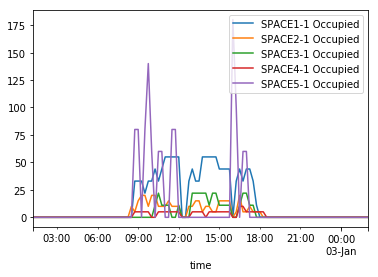

In [21]:
df[100:200][[
    'SPACE1-1 Occupied', 
    'SPACE2-1 Occupied', 
    'SPACE3-1 Occupied', 
    'SPACE4-1 Occupied', 
    'SPACE5-1 Occupied'
]].plot()

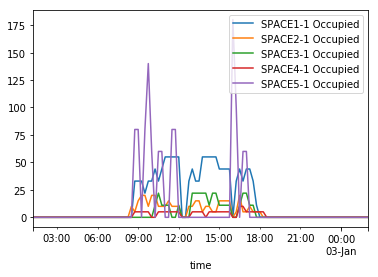

In [23]:
df1[100:200][[
    'SPACE1-1 Occupied', 
    'SPACE2-1 Occupied', 
    'SPACE3-1 Occupied', 
    'SPACE4-1 Occupied', 
    'SPACE5-1 Occupied'
]].plot()

In [24]:
df1.equals(df)

True

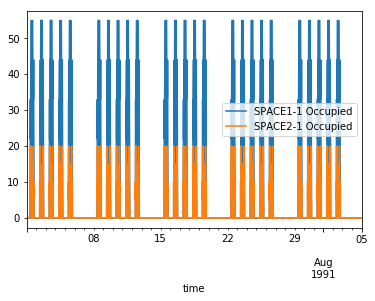

In [11]:
df[['SPACE1-1 Occupied', 'SPACE2-1 Occupied']].plot()

In [ ]:
print('hellow world')

In [13]:
# df.to_csv('SAT_SP_heating_blindsNone_daylightingFalse.csv')

In [5]:
# run('heating', False, False)
%time df = run('heating', True, True)
# run('heating', True, False)
# run('heating', True, True)

# run('cooling', False, False)
# run('cooling', False, True)
# run('cooling', True, False)
# run('cooling', True, True)

running heating_blindsTrue_daylightingTrue.csv


/Users/Gaby/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:837: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


CPU times: user 1.38 s, sys: 332 ms, total: 1.72 s
Wall time: 26.3 s


In [5]:
# run('heating', False, False)
%time df = run('heating', True, True)
# run('heating', True, False)
# run('heating', True, True)

# run('cooling', False, False)
# run('cooling', False, True)
# run('cooling', True, False)
# run('cooling', True, True)

running heating_blindsTrue_daylightingTrue.csv


/Users/Gaby/anaconda3/lib/python3.6/site-packages/pandas/core/arrays/datetimes.py:837: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


CPU times: user 1.77 s, sys: 461 ms, total: 2.23 s
Wall time: 33.9 s


In [6]:
df.columns

Index(['Outdoor Temp.', 'Diff. Solar Rad.', 'Direct Solar Rad.', 'HVAC Power',
       'Sys Out Temp.', 'Heat Coil Power', 'Cool Coil Power', 'Occupancy Flag',
       'MA Temp.', 'Indoor Temp. Setpoint', 'PPD', 'PPD Zone 1', 'PPD Zone 2',
       'PPD Zone 3', 'PPD Zone 4', 'PPD Zone 5', 'PMV Zone 1', 'PMV Zone 2',
       'PMV Zone 3', 'PMV Zone 4', 'PMV Zone 5', 'Indoor Temp.', 'Temp Zone 1',
       'Temp Zone 2', 'Temp Zone 3', 'Temp Zone 4', 'Temp Zone 5',
       'Lights Zone 1', 'Lights Zone 2', 'Lights Zone 3', 'Lights Zone 4',
       'Lights Zone 5', 'Shade On Zone 1', 'Blind Angle Zone 1',
       'Illuminance 1', 'Illuminance Exceeded 1', 'Glare 1',
       'Glare Exceeded 1', 'Illuminance 2', 'Illuminance Exceeded 2',
       'Glare 2', 'Glare Exceeded 2', 'time'],
      dtype='object')

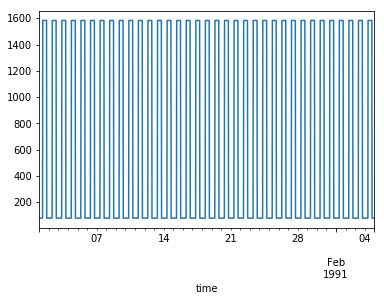

In [7]:
df['Lights Zone 1'].plot()

In [13]:
ep_model.get_configuration('SCHEDULE:COMPACT', 'DaylightingAvail')


Schedule:Compact,
    DaylightingAvail,         !- Name
    Fraction,                 !- Schedule Type Limits Name
    Through: 12/31,           !- Field 1
    For: AllDays,             !- Field 2
    Until: 24:00,             !- Field 3
    1;                        !- Field 4

In [ ]:
ep_model.edit_configuration('SCHEDULE:COMPACT', {'Name': 'DaylightingAvail'}, {
    'Field 4': dlight
})